In [1]:
import numpy as np
import matplotlib.pyplot as plt
import csv
import sys
import seaborn as sns
from scipy.special import comb
from sklearn.preprocessing import PolynomialFeatures
from matplotlib.colors import LogNorm
import matplotlib as mpl
import pandas as pd
import itertools as it
import matplotlib.colors as colors

from mutation_info import *

def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return it.chain.from_iterable(it.combinations(s, r) for r in range(len(s)+1))

plt.rcParams.update({'font.size': 7})
plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams['font.family'] = "sans-serif"
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams["xtick.major.size"] = 2
plt.rcParams["ytick.major.size"] = 2

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap


In [2]:
# set some things
num_mutations_MA = 16
order_MA = 5
num_term_list_MA = np.array([int(comb(num_mutations_MA,i)) for i in range(1,order_MA+1)])
total_params_MA = sum(num_term_list_MA)
order_start_indices_MA = list(np.cumsum(num_term_list_MA)+1)
order_start_indices_MA.insert(0,1)
print(num_term_list_MA,total_params_MA)
print(order_start_indices_MA)

num_mutations_SI = 15
order_SI = 5
num_term_list_SI = np.array([int(comb(num_mutations_SI,i)) for i in range(1,order_SI+1)])
total_params_SI = sum(num_term_list_SI)
order_start_indices_SI = list(np.cumsum(num_term_list_SI)+1)
order_start_indices_SI.insert(0,1)
print(num_term_list_SI,total_params_SI)
print(order_start_indices_SI)

num_mutations_G189E = 16
order_G189E = 5
num_term_list_G189E = np.array([int(comb(num_mutations_G189E,i)) for i in range(1,order_G189E+1)])
total_params_G189E = sum(num_term_list_G189E)
order_start_indices_G189E = list(np.cumsum(num_term_list_G189E)+1)
order_start_indices_G189E.insert(0,1)
print(num_term_list_G189E,total_params_G189E)
print(order_start_indices_G189E)


mut_names = ['N26D','S29R','Y35N','Y48C','D49Y','V98I','G31D','Y33H','M34I','H35N','N52H','G57D','L83V','S84N','R85G','R87K']

MA_color = '#E8735C'
SI_color = 'teal'
G189E_color = 'powderblue'


ep_type = 'biochem'

[  16  120  560 1820 4368] 6884
[1, 17, 137, 697, 2517, 6885]
[  15  105  455 1365 3003] 4943
[1, 16, 121, 576, 1941, 4944]
[  16  120  560 1820 4368] 6884
[1, 17, 137, 697, 2517, 6885]


# MA90

In [3]:
# read model coefficients
coefs_MA = np.zeros(total_params_MA+1)
stderr_MA = np.zeros(total_params_MA+1)
names_MA = []
sig_MA = np.full((total_params_MA+1),0)
cis_MA = np.zeros((total_params_MA+1,2))

with open('../../Epistasis_Inference/MA90/biochemical/CH65_MA90_'+str(order_MA)+'order_biochem.txt','r') as readfile:
    coef_reader = csv.reader(readfile,delimiter='\t')
    num_params = int(next(coef_reader)[-1])
    r2_train = float(next(coef_reader)[-1])
    print(r2_train)
    header = next(coef_reader)
    print(header)
    for i in range(total_params_MA+1):
        row = next(coef_reader)
        names_MA.append(row[0])
        coefs_MA[i] = float(row[1])
        if i >= 1:
            stderr_MA[i] = float(row[2])
            cis_MA[i,0] = float(row[4])
            cis_MA[i,1] = float(row[5])
            if float(row[4])*float(row[5]) > 0:
                sig_MA[i] = 1
    readfile.close()
            
print(len(coefs_MA))      

0.9899620201178291
['Term', 'Coefficient', 'Standard Error', 'p-value', '95% CI lower', '95% CI upper']
6885


0.0 6.404450540758404


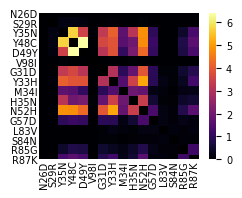

In [36]:
# initialize matrices to store values

# total (lower diagonal)
total_epistasis = np.zeros((16,16),dtype=float)
for i in range(16):  
    total_epistasis[i,i] = np.nan


# add up all coefficients
for i in range(1,len(coefs_MA)):

    muts_involved = [int(x)-1 for x in names_MA[i].split(',')]
    
    # only consider 2nd order and higher
    if len(muts_involved) >= 2:
        if sig_MA[i]:
            for j in range(len(muts_involved)):
                for k in range(j+1,len(muts_involved)):
                    total_epistasis[muts_involved[k],muts_involved[j]] += np.abs(coefs_MA[i])
                    total_epistasis[muts_involved[j],muts_involved[k]] += np.abs(coefs_MA[i])


print(np.nanmin(total_epistasis),np.nanmax(total_epistasis))

sns.set_style({"axes.facecolor": "k"})       
plt.figure(figsize=(2.5,2))
sns.heatmap(total_epistasis,cmap='inferno',cbar_kws={"pad": 0.05},vmax=np.nanmax(total_epistasis)) #,vmin=0.0,vmax=np.nanmax(total_epistasis)) 
plt.xticks(np.arange(0.5,num_mutations_MA+0.5,1),mut_names,rotation='90')
plt.yticks(np.arange(0.5,num_mutations_MA+0.5,1),mut_names,rotation='0')
plt.tick_params(length=0,pad=1)



plt.tight_layout()
plt.savefig('images/CH65_MA_2andup_biochem_total_'+ep_type+'.pdf')
plt.show()



56 627 6185 6868
1.0102010059042223 3.698700638351447 15.765864717302062
0.018039303676861112 0.005899044080305338 0.0025490484587392176
51 578 6000


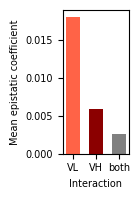

In [37]:
# define variables
light_ep = 0
heavy_ep = 0
between_ep = 0
light_ct = 0
heavy_ct = 0
between_ct = 0
light_int = []
heavy_int = []
between_int = []
light_chain = [0,1,2,3,4,5]
heavy_chain = [6,7,8,9,10,11,12,13,14,15]

#calculate total number of possible interactions within and between chains for normalization
num_term_list_light = np.array([int(comb(6,i)) for i in range(1,5+1)])
light_N = sum(num_term_list_light)-len(light_chain)
num_term_list_heavy = np.array([int(comb(10,i)) for i in range(1,5+1)])
heavy_N = sum(num_term_list_heavy)-len(heavy_chain)
num_term_list_total = np.array([int(comb(16,i)) for i in range(1,5+1)])
total_N = sum(num_term_list_total)-16
between_N = total_N - light_N - heavy_N
print(light_N,heavy_N,between_N,total_N)


# initialize matrices to store values
total_epistasis = np.zeros((16,16),dtype=float)
for i in range(16):  
    total_epistasis[i,i] = np.nan


# add up all coefficients
for i in range(1,len(coefs_MA)):

    muts_involved = [int(x)-1 for x in names_MA[i].split(',')]
    
    # only consider 2nd order and higher
    if len(muts_involved) >= 2:
        if all(elem in light_chain for elem in muts_involved):
            if sig_MA[i]:
                light_ep += np.abs(coefs_MA[i])
                light_int.append(coefs_MA[i])
            else:
                light_ct+=1
        elif all(elem in heavy_chain for elem in muts_involved):
            if sig_MA[i]:
                heavy_ep += np.abs(coefs_MA[i])
                heavy_int.append(coefs_MA[i])
            else:
                heavy_ct+=1
        else:
            if sig_MA[i]:
                between_ep += np.abs(coefs_MA[i])
                between_int.append(coefs_MA[i])
            else:
                between_ct+=1
    
#normalize by total number of possible interactions
light_ep_norm = light_ep/light_N
heavy_ep_norm = heavy_ep/heavy_N
between_ep_norm = between_ep/between_N
light_per = light_ct/light_N
heavy_per = heavy_ct/heavy_N
between_per = between_ct/between_N

print(light_ep,heavy_ep,between_ep)
toplot =[light_ep_norm,heavy_ep_norm,between_ep_norm]
print(light_ep_norm,heavy_ep_norm,between_ep_norm)
print(light_ct,heavy_ct,between_ct)

sns.set_style({"axes.facecolor": "w"})  
plt.figure(figsize=(1.4,2))
plt.bar(range(1,4),toplot,width=0.6,color=('tomato','darkred','gray'),label='MA90')
plt.ylabel('Mean epistatic coefficient')
plt.xlabel('Interaction')
plt.xticks([1,2,3],['VL','VH','both'])
plt.tight_layout()
plt.savefig('images/CH65_MA_ep_chains.pdf',transparent=True)
plt.show()

/Users/angelaphillips/opt/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 22.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


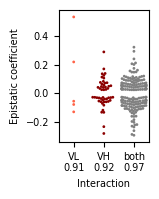

In [40]:
l = {'light': light_int}
h = {'heavy': heavy_int}
b = {'between' : between_int}
light_df = pd.DataFrame(data=l)
heavy_df = pd.DataFrame(data=h)
between_df = pd.DataFrame(data=b)
df = pd.concat([light_df,heavy_df,between_df], axis=1)

sns.set_style({"axes.facecolor": "w"})  
plt.figure(figsize=(1.6,2))
sns.swarmplot(data=df,palette=('tomato','darkred','gray'),size=2) 
plt.ylabel('Epistatic coefficient')
plt.xlabel('Interaction')
plt.xticks([0,1,2],['VL\n'+str(round(light_per,2)),'VH\n'+str(round(heavy_per,2)),'both\n'+str(round(between_per,2))])
plt.tight_layout()
plt.savefig('images/CH65_MA_ep_chains_box.pdf',transparent=True)
plt.show()

# SI06

In [41]:
# read model coefficients


coefs_SI = np.zeros(total_params_SI+1)
stderr_SI = np.zeros(total_params_SI+1)
names_SI = []
sig_SI = np.full((total_params_SI+1),0)
cis_SI = np.zeros((total_params_SI+1,2))

with open('../../Epistasis_Inference/SI06/biochemical/CH65_SI06_newdata_'+str(order_SI)+'order_biochem.txt','r') as readfile:
    coef_reader = csv.reader(readfile,delimiter='\t')
    num_params = int(next(coef_reader)[-1])
    r2_train = float(next(coef_reader)[-1])
    header = next(coef_reader)
    print(header)
    for i in range(total_params_SI+1):
        row = next(coef_reader)
        names_SI.append(row[0])
        coefs_SI[i] = float(row[1])
        if i >= 1:
            stderr_SI[i] = float(row[2])
            cis_SI[i,0] = float(row[4])
            cis_SI[i,1] = float(row[5])
            if float(row[4])*float(row[5]) > 0:
                sig_SI[i] = 1
    readfile.close()
            
print(len(coefs_SI))  

['Term', 'Coefficient', 'Standard Error', 'p-value', '95% CI lower', '95% CI upper']
4944


0.0 44.23160378360386


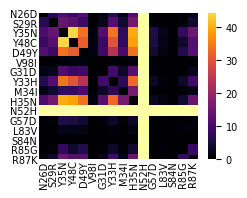

In [43]:
# combine MA and SI

# initialize matrices to store values
total_epistasis = np.zeros((num_mutations_MA,num_mutations_MA),dtype=float)


    
muts_SI = np.array([1,2,3,4,5,6,7,8,9,10,12,13,14,15,16])-1



for i in range(1,len(coefs_SI)):
    muts_involved = [int(x)-1 for x in names_SI[i].split(',')]
    if len(muts_involved) >= 2:
        if sig_SI[i]:
            for j in range(len(muts_involved)):
                for k in range(j+1,len(muts_involved)):
                    total_epistasis[muts_involved[k],muts_involved[j]] += np.abs(coefs_SI[i])
                    total_epistasis[muts_involved[j],muts_involved[k]] += np.abs(coefs_SI[i])


print(np.nanmin(total_epistasis),np.nanmax(total_epistasis))
min_val = np.nanmin(total_epistasis)
max_val = np.nanmax(total_epistasis)


overlay = np.full((num_mutations_MA,num_mutations_MA),np.nan)

for i in range(num_mutations_MA):
    overlay[i,i] = np.nan
    total_epistasis[i,i] = np.nan

    for j in [11]:
        overlay[j-1,i] = 1
        total_epistasis[j-1,i] = np.nan
        overlay[i,j-1] = 1
        total_epistasis[i,j-1] = np.nan
            
    
mpl.rc_file_defaults() 
plt.rcParams.update({'font.size': 7,"axes.facecolor": "k"})


cmap = plt.get_cmap('inferno')
new_cmap = truncate_colormap(cmap, 0,0.9)


plt.figure(figsize=(2.5,2))

sns.heatmap(total_epistasis,cmap=new_cmap,cbar_kws={"pad": 0.05},vmax=np.nanmax(total_epistasis)) 
sns.heatmap(overlay,cmap=cmap,vmin=0,vmax=1,cbar=None) 

plt.xticks(np.arange(0.5,num_mutations_MA+0.5,1),mut_names,rotation='90')
plt.yticks(np.arange(0.5,num_mutations_MA+0.5,1),mut_names,rotation='0')
plt.tick_params(length=0,pad=1)

plt.tight_layout()
plt.savefig('images/CH65_SI_2andup_biochem_total_'+ep_type+'.pdf')

plt.show()

[ 6 15 20 15  6]
[  9  36  84 126 126]
[  15  105  455 1365 3003]
56 372 4499 4927
10.441623611359265 4.595756497798315 111.5894829562692
0.1864575644885583 0.01235418413386644 0.02480317469576999
38 359 4215


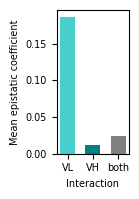

In [51]:
# define variables
light_ep = 0
heavy_ep = 0
between_ep = 0
light_ct = 0
heavy_ct = 0
between_ct = 0
light_chain = [0,1,2,3,4,5]
heavy_chain = [6,7,8,9,11,12,13,14,15]
light_int = []
heavy_int = []
between_int = []

#calculate total number of possible interactions within and between chains for normalization
num_term_list_light = np.array([int(comb(6,i)) for i in range(1,5+1)])
print(num_term_list_light)
light_N = sum(num_term_list_light)-len(light_chain)
num_term_list_heavy = np.array([int(comb(9,i)) for i in range(1,5+1)])
heavy_N = sum(num_term_list_heavy)-len(heavy_chain)
print(num_term_list_heavy)
num_term_list_total = np.array([int(comb(15,i)) for i in range(1,5+1)])
print(num_term_list_total)
total_N = sum(num_term_list_total)-16
between_N = total_N - light_N - heavy_N
print(light_N,heavy_N,between_N,total_N)


# initialize matrices to store values
total_epistasis = np.zeros((16,16),dtype=float)
for i in range(16):  
    total_epistasis[i,i] = np.nan


# add up all coefficients
for i in range(1,len(coefs_SI)):

    muts_involved = [int(x)-1 for x in names_SI[i].split(',')]
    
    # only consider 2nd order and higher
    if len(muts_involved) >= 2:
        if all(elem in light_chain for elem in muts_involved):
            if sig_SI[i]:
#                 print(muts_involved)
#                 print(coefs_SI[i])
                light_ep += np.abs(coefs_SI[i])
                light_int.append(coefs_SI[i])
            else:
                light_ct+=1
        elif all(elem in heavy_chain for elem in muts_involved):
            if sig_SI[i]:
#                 print(muts_involved)
#                 print(coefs_SI[i])
                heavy_ep += np.abs(coefs_SI[i])
                heavy_int.append(coefs_SI[i])
            else:
                heavy_ct+=1
        else:
            if sig_SI[i]:
#                 print(muts_involved)
#                 print(coefs_SI[i])
                between_ep += np.abs(coefs_SI[i])
                between_int.append(coefs_SI[i])
            else:
                between_ct+=1
    
#normalize by total number of possible interactions
light_ep_norm = light_ep/light_N
heavy_ep_norm = heavy_ep/heavy_N
between_ep_norm = between_ep/between_N
light_per = light_ct/light_N
heavy_per = heavy_ct/heavy_N
between_per = between_ct/between_N

print(light_ep,heavy_ep,between_ep)
toplot =[light_ep_norm,heavy_ep_norm,between_ep_norm]
print(light_ep_norm,heavy_ep_norm,between_ep_norm)
print(light_ct,heavy_ct,between_ct)

sns.set_style({"axes.facecolor": "w"})  
plt.figure(figsize=(1.4,2))
plt.bar(range(1,4),toplot,width=0.6,color=('mediumturquoise','teal','gray'),label='SI06')
#plt.ylim([0,1])
plt.ylabel('Mean epistatic coefficient')
plt.xlabel('Interaction')
plt.xticks([1,2,3],['VL','VH','both'])
plt.tight_layout()
plt.savefig('images/CH65_SI_ep_chains.pdf',transparent=True)
plt.show()

/Users/angelaphillips/opt/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 47.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


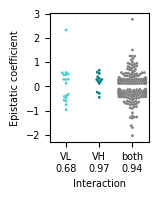

In [45]:
l = {'light': light_int}
h = {'heavy': heavy_int}
b = {'between' : between_int}
light_df = pd.DataFrame(data=l)
heavy_df = pd.DataFrame(data=h)
between_df = pd.DataFrame(data=b)
df = pd.concat([light_df,heavy_df,between_df], axis=1)

sns.set_style({"axes.facecolor": "w"})  
plt.figure(figsize=(1.6,2))
sns.swarmplot(data=df,palette=('mediumturquoise','teal','gray'),size=2) 
plt.ylabel('Epistatic coefficient')
plt.xlabel('Interaction')
plt.xticks([0,1,2],['VL\n'+str(round(light_per,2)),'VH\n'+str(round(heavy_per,2)),'both\n'+str(round(between_per,2))])
plt.tight_layout()
plt.savefig('images/CH65_SI_ep_chains_box.pdf',transparent=True)
plt.show()

## G189E

In [47]:
# read model coefficients
coefs_G189E = np.zeros(total_params_G189E+1)
stderr_G189E = np.zeros(total_params_G189E+1)
names_G189E = []
sig_G189E = np.full((total_params_G189E+1),0)
cis_G189E = np.zeros((total_params_G189E+1,2))

with open('../../Epistasis_Inference/G189E/biochemical/CH65_G189E_newdata_'+str(order_G189E)+'order_biochem.txt','r') as readfile:
    coef_reader = csv.reader(readfile,delimiter='\t')
    num_params = int(next(coef_reader)[-1])
    r2_train = float(next(coef_reader)[-1])
    print(r2_train)
    header = next(coef_reader)
    print(header)
    for i in range(total_params_G189E+1):
        row = next(coef_reader)
        names_G189E.append(row[0])
        coefs_G189E[i] = float(row[1])
        if i >= 1:
            stderr_G189E[i] = float(row[2])
            cis_G189E[i,0] = float(row[4])
            cis_G189E[i,1] = float(row[5])
            if float(row[4])*float(row[5]) > 0:
                sig_G189E[i] = 1
    readfile.close()
            
print(len(coefs_G189E))      

0.9730791082278677
['Term', 'Coefficient', 'Standard Error', 'p-value', '95% CI lower', '95% CI upper']
6885


0.0 33.312757504737775


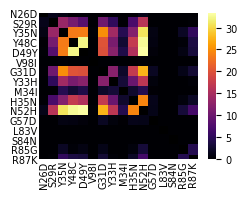

In [48]:
# initialize G189Etrices to store values

# total (lower diagonal)
total_epistasis = np.zeros((16,16),dtype=float)
for i in range(16):  
    total_epistasis[i,i] = np.nan


# add up all coefficients
for i in range(1,len(coefs_G189E)):

    muts_involved = [int(x)-1 for x in names_G189E[i].split(',')]
    
    # only consider 2nd order and higher
    if len(muts_involved) >= 2:
        if sig_G189E[i]:
            for j in range(len(muts_involved)):
                for k in range(j+1,len(muts_involved)):
                    total_epistasis[muts_involved[k],muts_involved[j]] += np.abs(coefs_G189E[i])
                    total_epistasis[muts_involved[j],muts_involved[k]] += np.abs(coefs_G189E[i])


print(np.nanmin(total_epistasis),np.nanmax(total_epistasis))

    
sns.set_style({"axes.facecolor": "k"})       
plt.figure(figsize=(2.5,2))
sns.heatmap(total_epistasis,cmap='inferno',cbar_kws={"pad": 0.05},vmax=np.nanmax(total_epistasis)) #,vmin=0.0,vG189Ex=np.nanG189Ex(total_epistasis)) 
plt.xticks(np.arange(0.5,num_mutations_G189E+0.5,1),mut_names,rotation='90')
plt.yticks(np.arange(0.5,num_mutations_G189E+0.5,1),mut_names,rotation='0')
plt.tick_params(length=0,pad=1)



plt.tight_layout()
plt.savefig('images/CH65_G189E_2andup_biochem_total_'+ep_type+'.pdf')
plt.show()



56 627 6185 6868
5.569227730804128 10.183450921633485 93.28331003893454
0.09945049519293085 0.01624154851935165 0.01508218432319071
48 606 5980


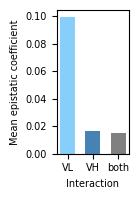

In [52]:
# define variables
light_ep = 0
heavy_ep = 0
between_ep = 0
light_ct = 0
heavy_ct = 0
between_ct = 0
light_chain = [0,1,2,3,4,5]
heavy_chain = [6,7,8,9,10,11,12,13,14,15]
light_int = []
heavy_int = []
between_int = []

#calculate total number of possible interactions within and between chains for normalization
num_term_list_light = np.array([int(comb(6,i)) for i in range(1,5+1)])
light_N = sum(num_term_list_light)-len(light_chain)
num_term_list_heavy = np.array([int(comb(10,i)) for i in range(1,5+1)])
heavy_N = sum(num_term_list_heavy)-len(heavy_chain)
num_term_list_total = np.array([int(comb(16,i)) for i in range(1,5+1)])
total_N = sum(num_term_list_total)-16
between_N = total_N - light_N - heavy_N
print(light_N,heavy_N,between_N,total_N)


# initialize matrices to store values
total_epistasis = np.zeros((16,16),dtype=float)
for i in range(16):  
    total_epistasis[i,i] = np.nan


# add up all coefficients
for i in range(1,len(coefs_G189E)):

    muts_involved = [int(x)-1 for x in names_G189E[i].split(',')]
    
    # only consider 2nd order and higher
    if len(muts_involved) >= 2:
        if all(elem in light_chain for elem in muts_involved):
            if sig_G189E[i]:
#                 print(muts_involved)
#                 print(coefs_G189E[i])
                light_ep += np.abs(coefs_G189E[i])
                light_int.append(coefs_G189E[i])
            else:
                light_ct+=1
        elif all(elem in heavy_chain for elem in muts_involved):
            if sig_G189E[i]:
#                 print(muts_involved)
#                 print(coefs_G189E[i])
                heavy_ep += np.abs(coefs_G189E[i])
                heavy_int.append(coefs_G189E[i])
            else:
                heavy_ct+=1
        else:
            if sig_G189E[i]:
#                 print(muts_involved)
#                 print(coefs_G189E[i])
                between_ep += np.abs(coefs_G189E[i])
                between_int.append(coefs_G189E[i])
            else:
                between_ct+=1
    
#normalize by total number of possible interactions
light_ep_norm = light_ep/light_N
heavy_ep_norm = heavy_ep/heavy_N
between_ep_norm = between_ep/between_N
light_per = light_ct/light_N
heavy_per = heavy_ct/heavy_N
between_per = between_ct/between_N

print(light_ep,heavy_ep,between_ep)
toplot =[light_ep_norm,heavy_ep_norm,between_ep_norm]
print(light_ep_norm,heavy_ep_norm,between_ep_norm)
print(light_ct,heavy_ct,between_ct)

sns.set_style({"axes.facecolor": "w"})  
plt.figure(figsize=(1.4,2))
plt.bar(range(1,4),toplot,width=0.6,color=('lightskyblue','steelblue','gray'),label='G189E')
#plt.ylim([0,1])
plt.ylabel('Mean epistatic coefficient')
plt.xlabel('Interaction')
plt.xticks([1,2,3],['VL','VH','both'])
plt.tight_layout()
plt.savefig('images/CH65_G189E_ep_chains.pdf',transparent=True)
plt.show()

/Users/angelaphillips/opt/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 34.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


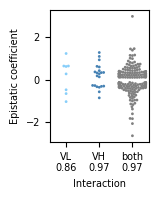

In [50]:
l = {'light': light_int}
h = {'heavy': heavy_int}
b = {'between' : between_int}
light_df = pd.DataFrame(data=l)
heavy_df = pd.DataFrame(data=h)
between_df = pd.DataFrame(data=b)
df = pd.concat([light_df,heavy_df,between_df], axis=1)

sns.set_style({"axes.facecolor": "w"})  
plt.figure(figsize=(1.6,2))
sns.swarmplot(data=df,size=2,palette=('lightskyblue','steelblue','gray')) 
plt.ylabel('Epistatic coefficient')
plt.xlabel('Interaction')
plt.xticks([0,1,2],['VL\n'+str(round(light_per,2)),'VH\n'+str(round(heavy_per,2)),'both\n'+str(round(between_per,2))])
plt.tight_layout()
plt.savefig('images/CH65_G189E_ep_chains_box.pdf',transparent=True)
plt.show()